## Exercise 1: Load images and create random distortions

We provide the function `load_random_simpsons_face(N, D, duplicates=False)` which loads and returns `N` random faces of size `DxD` (optionally with duplicates), i.e. a `numpy` array of shape `(N, D, D, 3)`. The images are in the provided zip file and should be extractet automatically. Write a function `convert_images2bin_pattern(images)` which converts the images to black and white such that only $± 1$ pixel values are allowed and only one channel is retained. That is the RGB-image should be converted to a binary one. At the end the image should be reshaped to a vector such that the output of the convert function is of shape `(N,D**2)`.

Further, write a second function `corrupt_binary_patterns(patterns, p_flip)` that takes `patterns` of the form as returned by the first function and returns a corrupted copy of them. A pattern is corrupted by flipping each pixel with a probability of `p_flip`.

Test your functions and visualize the results. i.e. show the original image, the black-white image and the corrupted image. For binary patterns use the cmap `binary` for the function `show_images()`.

In [1]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from glob import glob
from tqdm.notebook import tqdm
import zipfile
from PIL import Image

np.random.seed(0)

def _load_images(image_paths, n_pixel):
    """helper function to load images from given paths

    Args:
        image_paths ([str]): list of strings indicating paths to images
        n_pixel (int): number of pixels per side for each image

    Returns:
        [PIL.Image.Image]: list of PIL.Image
    """
    images = []
    for path in image_paths:
        im = Image.open(path)
        im = im.resize((n_pixel,n_pixel))
        images.append(im)
    return images

def load_random_simpsons_face(N, D, duplicates=False):
    """extract zip file and loads a random number of images into numpy 
    array
    
    Args: 
        N (int): number of images to draw randomly
        D (int): number of pixels per side for each image
        duplicates (bool): defaults to False, if one image can be drawn multiple times
    
    Returns:
        np.ndarray: numpy array of images with shape N x D x D x 3
    
    """
    zippath = 'simpsons_faces.zip'
    zip_dest = zippath[:-4]
    if not os.path.exists(zip_dest):
        with zipfile.ZipFile(zippath, 'r') as zip_ref:
            zip_ref.extractall('.')
    
    img_paths = glob(zip_dest+'/**/*.png', recursive=True)
    selected_imgs = np.random.choice(img_paths, size=N, replace=duplicates)
    imgs = [np.array(x) for x in _load_images(selected_imgs,D)]
    
    return np.array(imgs)
    
    
def show_images(imgs, cmap=None):
    """plot images given as a numpy array in a row. Also reshapes
    patterns into images to plot them.
    
    
    Args:
        imgs (np.ndarray): batch of images as np.array of shape N x D x D x C
                           can also be a batch of patterns of shape N x D**2 
        cmap (None|str): optionally a string identifying a matplotlib.colormap
                         for binary patterns/images use 'binary'
                         for continuous patterns/images use 'gray'
        
    Returns:
        None
    """
    # imgs is of shape (batch, width, width, channel)
    # show images in a row
    if not cmap: # defaults to binary cmap if imags is batch of pattern 
        if imgs.ndim == 2:
            cmap = 'binary'
            
    if imgs.ndim == 2:
        # reshape pattern into img tensor with channel dim
        N, D2 = imgs.shape
        imgs = imgs.reshape(N, int(np.sqrt(D2)), -1,1)
    N, W, _, C = imgs.shape
    
    plt.figure()
    fig, axes = plt.subplots(1, N)
    axes = [axes] if N == 1 else axes
    for im, ax in zip(imgs, axes):
        ax.imshow(im, cmap=cmap)
        
    plt.show()

    
def convert_images2bin_pattern(images):
    """converts images to binary black and white with pixel values
    in set {-1,+1}

    Args:
        images (np.ndarray): batch of images as np.array of shape N x D x D x C

    Returns:
        np.ndarray: numpy array with shape N x D*D
    """
    N, D,_,C = images.shape
    
    #threshold = 256/2
    final_ar = np.empty((N,D**2))
    for ind, single_img in enumerate(images):
        pillow_img = Image.fromarray(single_img)
        gray_img = pillow_img.convert('L')
                
        bin_img = np.array(gray_img).astype('int') # store as int else we will have a character operation
        # when masking below        
        
        # getting median:
        med_values = np.sort(bin_img.flatten())
        med_ind = int(len(med_values)/2)
        
        if len(med_values) % 2 != 0: # list has odd length
            med = (med_values[med_ind] + med_values[med_ind+1])/2
        else:
            med = med_values[med_ind]
            
        bin_img[np.where(bin_img<med)] = 1
        bin_img[np.where(bin_img>=med)] = -1

        bin_img = bin_img.reshape(1, D**2)
        final_ar[ind] = bin_img
        
    return final_ar
    
    assert C == 3, 'invalid image shape'
########## YOUR SOLUTION HERE ##########


def corrupt_binary_patterns(patterns, p_flip=.1):
    """corrupts binary pattern by flipping each pixel with probability p_flip.
    A pixel is an element in {-1, +1}.
    
    Args:
        patterns (np.ndarray): batch of patterns as np.array of shape N x D**2
        
    Returns:
        np.ndarray: corrupted numpy array with same shape as patterns
    """

    
    pattern_dim = patterns.shape[0]*patterns.shape[1]
    value_range = 1 # only from 0 up to 1 as outputs where 1 will be the one which is connected to 
    # p_flip:
    mask = np.random.binomial(value_range, p_flip, pattern_dim).reshape(patterns.shape)
    
    patterns[np.where(mask==1)] *= (-1) # we flip sign from +/- to -/+ where the mask has value 1
    
    return patterns
    
    assert patterns.ndim == 2, 'inavlid pattern shape'
########## YOUR SOLUTION HERE ##########

<Figure size 432x288 with 0 Axes>

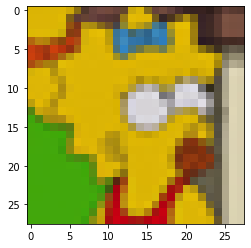

In [16]:
img_ar = load_random_simpsons_face(1, 28, duplicates=False)
show_images(img_ar, cmap=None);

<Figure size 432x288 with 0 Axes>

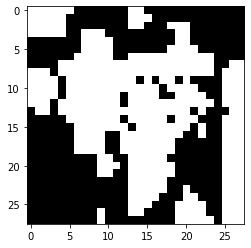

In [17]:
img_bin = convert_images2bin_pattern(img_ar)
show_images(img_bin, cmap='binary');

<Figure size 432x288 with 0 Axes>

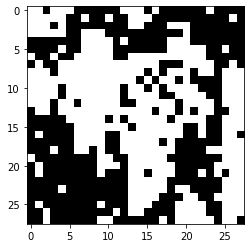

In [18]:
img_distort = corrupt_binary_patterns(img_bin)
show_images(img_distort, cmap='binary');

## Exercise 2: Batchify the Hopfield Network

Consider a Hopfield network with $D$ neurons. You are given a matrix $\mathbf{X} \in \{-1,+1\}^{N \times D}$ representing a batch of $N$ patterns. Write down the Hebbian weight matrix $\mathbf{W}$ that stores these patterns in a Hopfield network (cf. Eq. (5.16) in the script), the batched (synchronous) state update $\mathbf{X}^{\text{new}}$ for inital states $\mathbf{X}^{\text{old}}$ (cf. Eq. (5.12) in the script), and the average energy $E$ of the batch $\mathbf{X}$ (cf. Eq. (5.13) in the script). 

*Use only matrix operations for this! That is, do not decompose the matrices $\mathbf{X}, \mathbf{Q}, \mathbf{W}$ into vectors or single elements. This will enable us to implement the batched Hopfield network efficiently using standard linear algebra routines instead of looping over samples.*

*Do not use bias (threshold) units, i.e., assume them to be zero.*

*TLDR: Rewrite equations (5.12), (5.13), and (5.16) in matrix form neglecting bias terms.*

########## YOUR SOLUTION HERE ##########

Batched update for X:<br>
Equation 5.12 gives us:
$$
x^{new} = sign(W x^{old} - b ) \text{ where } b=0 \\
\text{Rewriting it in full matrix notation: } 
X^\top = sign(W X^\top)
$$

Average energy E of batch X:
Equation 5.13 gives us:
$$
E = - 0.5 x^\top W x + x^\top b \text{ where } b=0 \\
\text{Rewriting it in full matrix notation: } 
E = -0.5 diag(X W X^\top) \frac{1}{N} \\
\text{ where we used diag() to only consider the x-es touching themselves, e.g. x_1 meets x_1 on the first diagonal entry with} x_1 W x_1^\top \\
\text{1/N gives us the average energy per pattern within one batch.}
$$

Hebbian weight matrix W which stores the patterns in network: <br>
Equation 5.16 gives us:
$$
W = \frac{1}{N} \left( \sum_{n=1}^N x^{(n)} x^{(n)\top} \right) - I_D\\
\text{Rewriting it in full matrix notation: } 
W = \frac{1}{N} X^\top X - I_D
$$

## Exercise 3: Implement the Hopfield Network
Write the three functions `store(self,X)` and `retrieve(self,W, X)` and `energy(self,X)` for the class `ClassicalHopfield`. The first function should take a batch of patterns `X` and return the Hebbian weight matrix `W` that stores these patterns. The second function should a batch of states (e.g. corrupted patterns) `X` and should retrieve stored patterns by iterating the synchronous batched Hopfield dynamics established in the previous exercise. Stop the iteration when all states have converged. Compute and print the total energy of the network on every iteration. 

In [9]:
class ClassicalHopfield:
    """class providing the classical hopfield model which can learn patterns and retrieve them
    Attributes
    ----------
    size : int
        dimension D of single pattern vector 
    W : np.ndarray, DxD
        weight matrix of the hopfield network
    b : np.ndarray, D
        bias vector, in our case just set to 0
    
    Methods
    -------
    store(patterns) : None
        learn given array of patterns in {-1,1}^D, shape NxD with N=#of patterns, D=size of patterns
    retrieve(test_pat, reps=1) : np.ndarray
        retrieves a memorized pattern from the provided one
    """

    def __init__(self, pat_size):
        """Constructor of classical Hopfield network
        Args:
            pat_size (int): the dimension D of a single pattern vector
        """
        self.size = pat_size
        self.W = np.zeros((self.size,self.size))
        self.b = np.zeros(self.size)
        
    def store(self, X):
        """learns the weight matrix by applying hebbian learning rule 
        to the provided patterns, without self reference
        Args:
            X (np.ndarray):  NxD numpy arrays where patterns are row-wise
        """
        N, D = X.shape
                
        err_msg = f"Can't store patterns of size {D}. Need to initialize ClassicalHopfield with correct size"
        assert D == self.size, err_msg
        
        self.W = 1/N * X.T @ X - np.identity(D) # eq 5.16

        return 
        

        
########## YOUR SOLUTION HERE ##########
    
    def retrieve(self, X, reps=10, verbose=False):
        """[summary]
        Args:
            X (np.ndarray): the corrupted test patterns which should be retrieved
            reps (int, optional): number of times the retrieval update should be applied . Defaults to 1.
        Returns:
            np.ndarray: the retrieved pattern of shape Dx1
        """
        N, D = X.shape
        
        X_trans = X.T
        X_trans_old = X_trans - 5 # simply shouldnt be the same as X_trans in the first round of for-loop.:
        for t in range(reps):
            
            
            X_trans = np.sign(self.W @ X_trans) # eq 5.12 # getting a transposed X
            # use self.W to use the stored patterns
            
            
            if np.all(X_trans == X_trans_old): # all states converge
                break
                
            # on each iteration compute and print E:
            E = self.energy(X_trans.T)
            print(E, '\t as energy at time point ', t)
                
            X_trans_old = X_trans
            
        X = X_trans.T
        
        return X
        
########## YOUR SOLUTION HERE ##########
    
    def energy(self, X):
        """calculates energy for pattern batch according to hopfield model
        Args:
            X (np.ndarray): the patterns for which the energy should be calculated
        Returns:
            float: the calculated energy
        """
        
        #assert type(X) is np.ndarray # lassen??
        N, D = X.shape
        
        E = -0.5 * np.diag(X @ self.W @ X.T) # E for single samples
        
        # Getting total energy:
        E = np.sum(E) /N
        
        return E
    
########## YOUR SOLUTION HERE ##########


## Exercise 4: Test the Hopfield Network

To test your Hopfield network and initialize it for patterns of size 16*16, create a batch of 6 random faces with 256 neurons using `load_random_simpsons_face` and `convert_images2bin_pattern` and store them using `store(self,X)`. Then corrupt these patterns with a probability of a) 0.1 and b) 0.4 using `corrupt_binary_patterns` and try to restore the original patterns using `retrieve(self,X)`. 
Finally, answer the three following questions experimentally

*Question 1: What do you observe? Plot each step of your experiment. That is show the original images, the patterns, the corrupted and retrieved ones.*

*Question 2: Fixing the number of patterns to 5 and average over 100 trials, what is the maximum probability of flips the Hopfield network can handle? Give experimental evidence via some plots.*

*Question 3: Fixing the probability of flips to 0.4 and average over 100 trials, what is the maximum number of patterns the Hopfield network can restore? Give experimental evidence via some plots.*


Original images:



<Figure size 432x288 with 0 Axes>

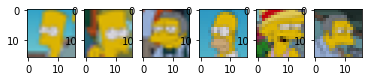


Binary versions:



<Figure size 432x288 with 0 Axes>

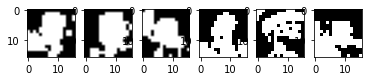


pixel flip with probability of  0.1

Corrupted pictures with probability of flipping =  0.1 :


<Figure size 432x288 with 0 Axes>

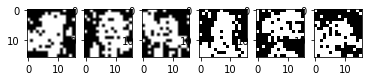

-45575.333333333314 	 as energy at time point  0
-46128.66666666667 	 as energy at time point  1
-46147.333333333336 	 as energy at time point  2
-46269.999999999985 	 as energy at time point  3

Redone pictures:



<Figure size 432x288 with 0 Axes>

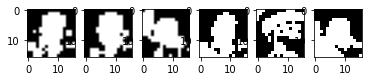


pixel flip with probability of  0.4

Corrupted pictures with probability of flipping =  0.4 :


<Figure size 432x288 with 0 Axes>

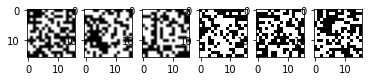

-45048.66666666665 	 as energy at time point  0
-47351.333333333336 	 as energy at time point  1
-47878.0 	 as energy at time point  2
-47890.0 	 as energy at time point  3
-48012.66666666665 	 as energy at time point  4

Redone pictures:



<Figure size 432x288 with 0 Axes>

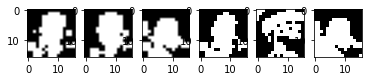

In [6]:
########## YOUR SOLUTION HERE ##########
img_batch = load_random_simpsons_face(6, 16)
print('Original images:\n')
show_images(img_batch) # Q1

img_bin_batch_X = convert_images2bin_pattern(img_batch)
print('\nBinary versions:\n')
show_images(img_bin_batch_X, cmap='binary') # Q1

field = ClassicalHopfield(256)
field.store(img_bin_batch_X) # adjust W

for prob in [0.1, 0.4]:
    print('\npixel flip with probability of ', prob)
    
    img_bin_batch_X1 = np.copy(img_bin_batch_X)
    
    # Distort patterns:
    img_distort_batch = corrupt_binary_patterns(img_bin_batch_X1, prob)
    print('\nCorrupted pictures with probability of flipping = ', prob, ':')
    show_images(img_distort_batch, cmap='binary') # Q1

    # Get the original patterns back:
    redone_pattern_X = field.retrieve(img_distort_batch)
    print('\nRedone pictures:\n')
    show_images(redone_pattern_X, cmap='binary') # Q1


Q1: Partwise the restoring of the pictures work well. The degree of distortion doesn't seem to play a big role. However, when restoring a certain kind of pattern gets prefered. 

Original images:



<Figure size 432x288 with 0 Axes>

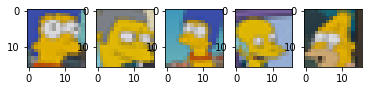


Binary versions:



<Figure size 432x288 with 0 Axes>

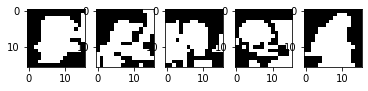


pixel flip with probability of  0.0

Corrupted pictures with probability of flipping =  0.0 :


<Figure size 432x288 with 0 Axes>

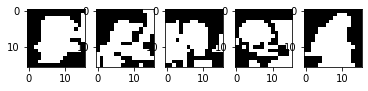

-8813.119999999992 	 as energy at time point  0
-8884.160000000007 	 as energy at time point  1
-9097.279999999995 	 as energy at time point  2
-9157.039999999999 	 as energy at time point  3

Redone pictures:



<Figure size 432x288 with 0 Axes>

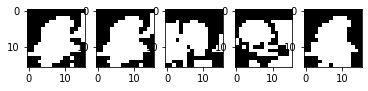


pixel flip with probability of  0.2

Corrupted pictures with probability of flipping =  0.2 :


<Figure size 432x288 with 0 Axes>

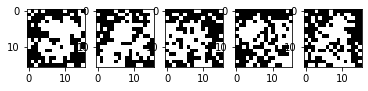

-8846.719999999992 	 as energy at time point  0
-8941.760000000004 	 as energy at time point  1
-9097.279999999995 	 as energy at time point  2
-9157.039999999999 	 as energy at time point  3

Redone pictures:



<Figure size 432x288 with 0 Axes>

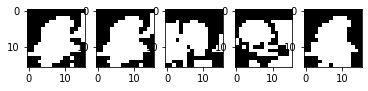


pixel flip with probability of  0.4

Corrupted pictures with probability of flipping =  0.4 :


<Figure size 432x288 with 0 Axes>

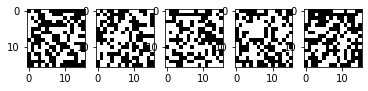

-8980.640000000003 	 as energy at time point  0
-9714.719999999992 	 as energy at time point  1
-9768.719999999994 	 as energy at time point  2

Redone pictures:



<Figure size 432x288 with 0 Axes>

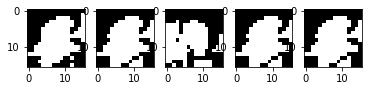


pixel flip with probability of  0.5

Corrupted pictures with probability of flipping =  0.5 :


<Figure size 432x288 with 0 Axes>

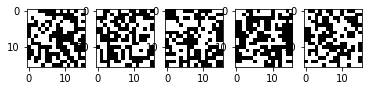

-6995.360000000001 	 as energy at time point  0
-8789.359999999995 	 as energy at time point  1
-9042.159999999998 	 as energy at time point  2
-9551.679999999997 	 as energy at time point  3
-9588.399999999998 	 as energy at time point  4

Redone pictures:



<Figure size 432x288 with 0 Axes>

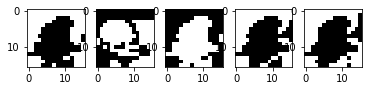


pixel flip with probability of  0.6

Corrupted pictures with probability of flipping =  0.6 :


<Figure size 432x288 with 0 Axes>

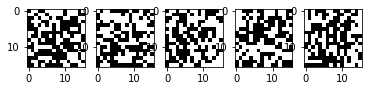

-8757.44 	 as energy at time point  0
-9167.920000000002 	 as energy at time point  1
-9239.280000000004 	 as energy at time point  2

Redone pictures:



<Figure size 432x288 with 0 Axes>

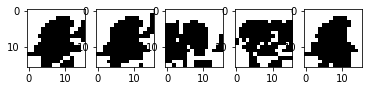


pixel flip with probability of  0.7

Corrupted pictures with probability of flipping =  0.7 :


<Figure size 432x288 with 0 Axes>

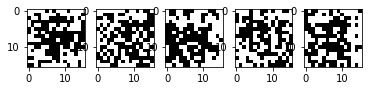

-8774.159999999982 	 as energy at time point  0
-9302.639999999989 	 as energy at time point  1
-9484.000000000005 	 as energy at time point  2
-9599.920000000002 	 as energy at time point  3

Redone pictures:



<Figure size 432x288 with 0 Axes>

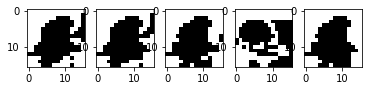


pixel flip with probability of  0.9

Corrupted pictures with probability of flipping =  0.9 :


<Figure size 432x288 with 0 Axes>

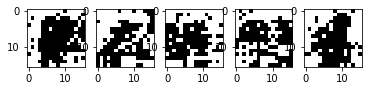

-8891.679999999997 	 as energy at time point  0
-9016.560000000003 	 as energy at time point  1
-9172.079999999996 	 as energy at time point  2
-9231.84 	 as energy at time point  3

Redone pictures:



<Figure size 432x288 with 0 Axes>

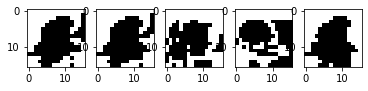


pixel flip with probability of  1

Corrupted pictures with probability of flipping =  1 :


<Figure size 432x288 with 0 Axes>

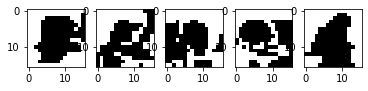

-8813.119999999992 	 as energy at time point  0
-8884.160000000007 	 as energy at time point  1
-9097.279999999995 	 as energy at time point  2
-9157.039999999999 	 as energy at time point  3

Redone pictures:



<Figure size 432x288 with 0 Axes>

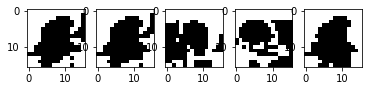

In [15]:
# Q2:

img_batch = load_random_simpsons_face(5, 16) # Use 5 patterns/images
print('Original images:\n')
show_images(img_batch) # Q1

img_bin_batch_X = convert_images2bin_pattern(img_batch)
print('\nBinary versions:\n')
show_images(img_bin_batch_X, cmap='binary') # Q1

field = ClassicalHopfield(256)
field.store(img_bin_batch_X) # adjust W

for prob in [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.9, 1]:
    print('\npixel flip with probability of ', prob)
    
    img_bin_batch_X1 = np.copy(img_bin_batch_X) # without generating copy the variable seems to change
    # corrupt_binary_patterns(). At least its distorted result is plotted instead of the original 
    # binary image using show_images()

    # Distort patterns:
    img_distort_batch = corrupt_binary_patterns(img_bin_batch_X1, prob)
    print('\nCorrupted pictures with probability of flipping = ', prob, ':')
    show_images(img_distort_batch, cmap='binary') # Q1

    # Get the original patterns back:
    redone_patterns_X = field.retrieve(img_distort_batch, 100) # update X 100 times
    print('\nRedone pictures:\n')
    show_images(redone_patterns_X, cmap='binary') # Q1


Q2: When p>=0.5 the negative of the original is predicted. So the overall pattern is restored but with vice versa pixel values. The more pixels we flip, the more similar it comes to the original undistorted pattern as negative. Also here the degree of distortion doesn't seem to have a high impact.<br>
Looking at the image pattern outputs we can observe that the network seems to have most struggles with p in the interval [0.4,0.6]. For p=0.4 four times almost the same pattern is predicted. For p=0.5 it's the same struggle but in addition the single picture predicted more or less right appears at the wrong position. So even worse. For p=0.6 one prediction seems to be nice whereas for the rest very similar patterns are predicted. <br>
Reason for obersevation: When flipping randomly with a probability of around 0.5 the pattern gets really messy and alomst destroyed. When flipping with a higher probability the pattern can survive. Therefore, it is harder to handle a uniform flipping. 

#####################################################
--> Number patterns: 1
Original images:



<Figure size 432x288 with 0 Axes>

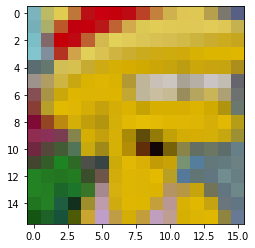


Binary versions:



<Figure size 432x288 with 0 Axes>

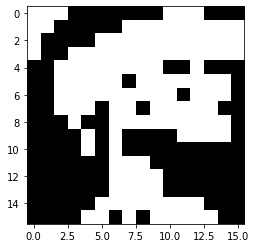


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

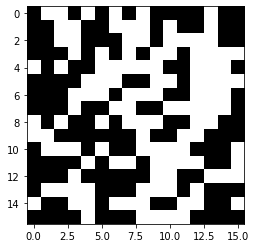

-32640.0 	 as energy at time point  0

Redone pictures:



<Figure size 432x288 with 0 Axes>

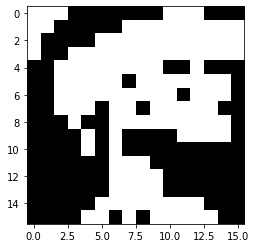

#####################################################
--> Number patterns: 2
Original images:



<Figure size 432x288 with 0 Axes>

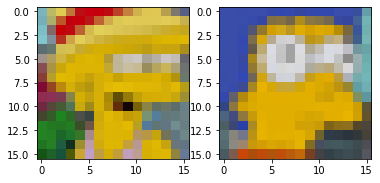


Binary versions:



<Figure size 432x288 with 0 Axes>

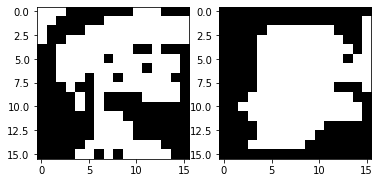


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

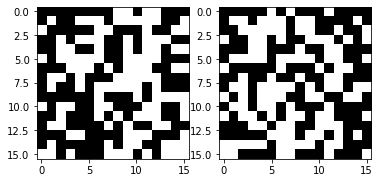

-17156.0 	 as energy at time point  0

Redone pictures:



<Figure size 432x288 with 0 Axes>

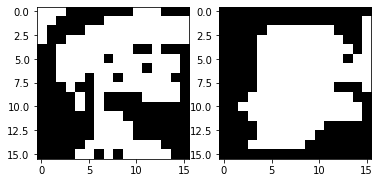

#####################################################
--> Number patterns: 3
Original images:



<Figure size 432x288 with 0 Axes>

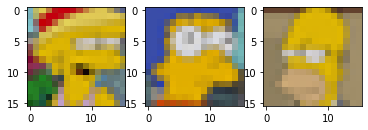


Binary versions:



<Figure size 432x288 with 0 Axes>

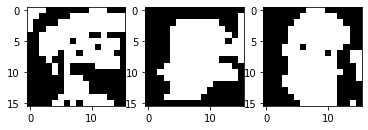


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

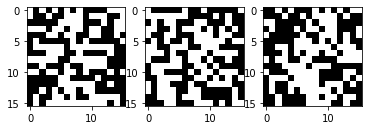

-14737.99999999997 	 as energy at time point  0
-15561.3333333333 	 as energy at time point  1

Redone pictures:



<Figure size 432x288 with 0 Axes>

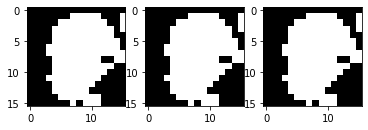

#####################################################
--> Number patterns: 4
Original images:



<Figure size 432x288 with 0 Axes>

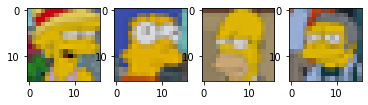


Binary versions:



<Figure size 432x288 with 0 Axes>

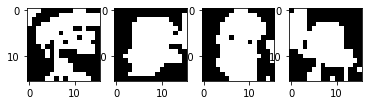


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

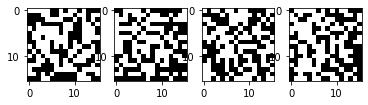

-10367.75 	 as energy at time point  0

Redone pictures:



<Figure size 432x288 with 0 Axes>

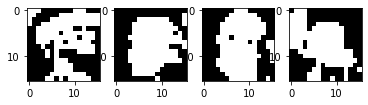

#####################################################
--> Number patterns: 5
Original images:



<Figure size 432x288 with 0 Axes>

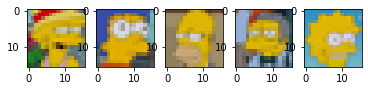


Binary versions:



<Figure size 432x288 with 0 Axes>

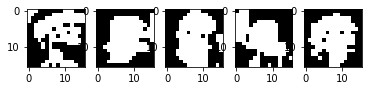


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

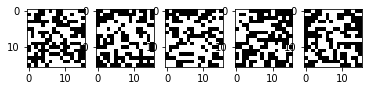

-10869.999999999995 	 as energy at time point  0
-10925.679999999998 	 as energy at time point  1

Redone pictures:



<Figure size 432x288 with 0 Axes>

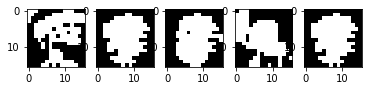

#####################################################
--> Number patterns: 6
Original images:



<Figure size 432x288 with 0 Axes>

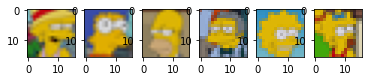


Binary versions:



<Figure size 432x288 with 0 Axes>

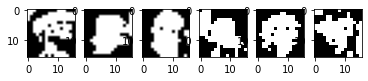


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

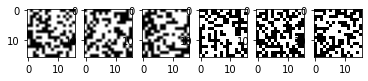

-10016.777777777776 	 as energy at time point  0
-11284.666666666677 	 as energy at time point  1
-11540.222222222226 	 as energy at time point  2
-11612.222222222219 	 as energy at time point  3
-11616.666666666659 	 as energy at time point  4

Redone pictures:



<Figure size 432x288 with 0 Axes>

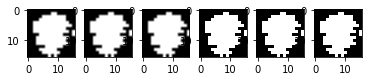

#####################################################
--> Number patterns: 7
Original images:



<Figure size 432x288 with 0 Axes>

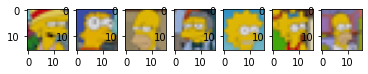


Binary versions:



<Figure size 432x288 with 0 Axes>

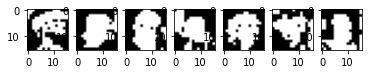


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

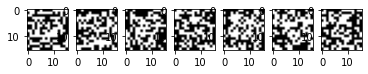

-9013.020408163266 	 as energy at time point  0
-10316.122448979586 	 as energy at time point  1
-10513.020408163267 	 as energy at time point  2
-10527.102040816331 	 as energy at time point  3

Redone pictures:



<Figure size 432x288 with 0 Axes>

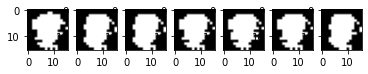

#####################################################
--> Number patterns: 8
Original images:



<Figure size 432x288 with 0 Axes>

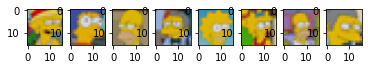


Binary versions:



<Figure size 432x288 with 0 Axes>

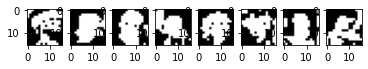


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

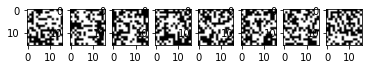

-7805.34375 	 as energy at time point  0
-8543.5 	 as energy at time point  1
-9148.4375 	 as energy at time point  2
-9389.625 	 as energy at time point  3
-9415.0625 	 as energy at time point  4
-9417.125 	 as energy at time point  5
-9424.125 	 as energy at time point  6

Redone pictures:



<Figure size 432x288 with 0 Axes>

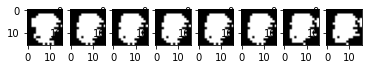

#####################################################
--> Number patterns: 9
Original images:



<Figure size 432x288 with 0 Axes>

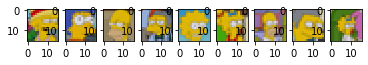


Binary versions:



<Figure size 432x288 with 0 Axes>

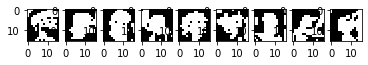


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

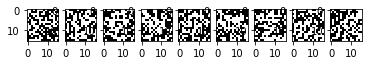

-7303.456790123459 	 as energy at time point  0
-8540.123456790128 	 as energy at time point  1
-8909.01234567901 	 as energy at time point  2
-8984.296296296297 	 as energy at time point  3
-9006.716049382716 	 as energy at time point  4
-9007.728395061726 	 as energy at time point  5
-9007.777777777776 	 as energy at time point  6

Redone pictures:



<Figure size 432x288 with 0 Axes>

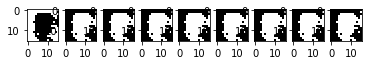

#####################################################
--> Number patterns: 10
Original images:



<Figure size 432x288 with 0 Axes>

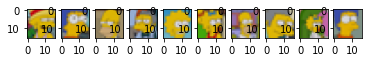


Binary versions:



<Figure size 432x288 with 0 Axes>

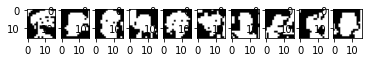


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

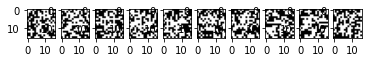

-8211.48 	 as energy at time point  0
-9272.92 	 as energy at time point  1
-9406.039999999997 	 as energy at time point  2
-9425.160000000003 	 as energy at time point  3
-9427.800000000005 	 as energy at time point  4

Redone pictures:



<Figure size 432x288 with 0 Axes>

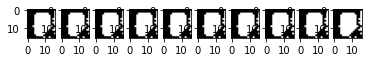

#####################################################
--> Number patterns: 11
Original images:



<Figure size 432x288 with 0 Axes>

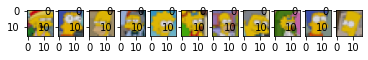


Binary versions:



<Figure size 432x288 with 0 Axes>

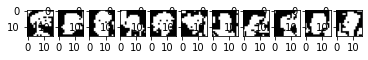


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

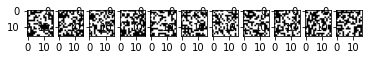

-8025.272727272727 	 as energy at time point  0
-8943.272727272728 	 as energy at time point  1
-9015.65289256198 	 as energy at time point  2
-9020.297520661152 	 as energy at time point  3
-9020.859504132228 	 as energy at time point  4
-9020.909090909086 	 as energy at time point  5

Redone pictures:



<Figure size 432x288 with 0 Axes>

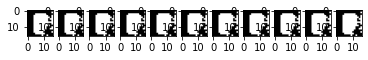

#####################################################
--> Number patterns: 12
Original images:



<Figure size 432x288 with 0 Axes>

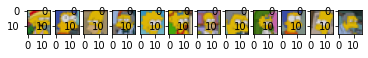


Binary versions:



<Figure size 432x288 with 0 Axes>

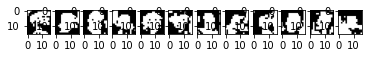


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

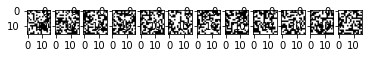

-6474.611111111112 	 as energy at time point  0
-8014.5277777777765 	 as energy at time point  1
-8363.777777777776 	 as energy at time point  2
-8393.749999999998 	 as energy at time point  3
-8397.333333333334 	 as energy at time point  4
-8397.722222222224 	 as energy at time point  5
-8397.91666666667 	 as energy at time point  6
-8397.944444444445 	 as energy at time point  7

Redone pictures:



<Figure size 432x288 with 0 Axes>

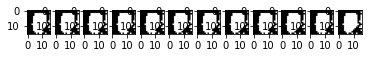

#####################################################
--> Number patterns: 13
Original images:



<Figure size 432x288 with 0 Axes>

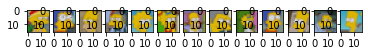


Binary versions:



<Figure size 432x288 with 0 Axes>

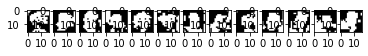


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

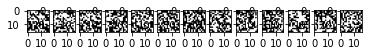

-6738.4378698224855 	 as energy at time point  0
-7974.1893491124265 	 as energy at time point  1
-8401.408284023664 	 as energy at time point  2
-8447.692307692301 	 as energy at time point  3
-8455.585798816564 	 as energy at time point  4
-8455.999999999996 	 as energy at time point  5

Redone pictures:



<Figure size 432x288 with 0 Axes>

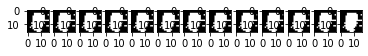

#####################################################
--> Number patterns: 14
Original images:



<Figure size 432x288 with 0 Axes>

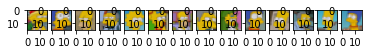


Binary versions:



<Figure size 432x288 with 0 Axes>

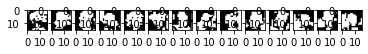


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

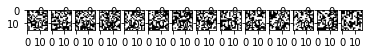

-6385.816326530612 	 as energy at time point  0
-7746.775510204081 	 as energy at time point  1
-8028.775510204081 	 as energy at time point  2
-8077.795918367346 	 as energy at time point  3
-8079.142857142855 	 as energy at time point  4

Redone pictures:



<Figure size 432x288 with 0 Axes>

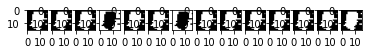

#####################################################
--> Number patterns: 15
Original images:



<Figure size 432x288 with 0 Axes>

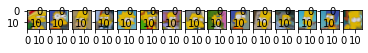


Binary versions:



<Figure size 432x288 with 0 Axes>

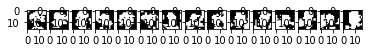


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

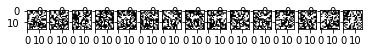

-6750.755555555554 	 as energy at time point  0
-7795.6622222222195 	 as energy at time point  1
-8204.26666666666 	 as energy at time point  2
-8249.351111111107 	 as energy at time point  3
-8253.662222222216 	 as energy at time point  4
-8254.497777777771 	 as energy at time point  5
-8254.533333333327 	 as energy at time point  6
-8254.533333333327 	 as energy at time point  7
-8254.533333333327 	 as energy at time point  8
-8254.533333333327 	 as energy at time point  9
-8254.533333333327 	 as energy at time point  10
-8254.533333333327 	 as energy at time point  11
-8254.533333333327 	 as energy at time point  12
-8254.533333333327 	 as energy at time point  13
-8254.533333333327 	 as energy at time point  14
-8254.533333333327 	 as energy at time point  15
-8254.533333333327 	 as energy at time point  16
-8254.533333333327 	 as energy at time point  17
-8254.533333333327 	 as energy at time point  18
-8254.533333333327 	 as energy at time point  19
-8254.533333333327 	 as energy

<Figure size 432x288 with 0 Axes>

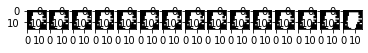

#####################################################
--> Number patterns: 16
Original images:



<Figure size 432x288 with 0 Axes>

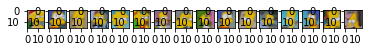


Binary versions:



<Figure size 432x288 with 0 Axes>

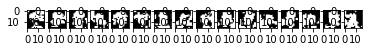


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

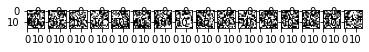

-6643.328125 	 as energy at time point  0
-7614.859375 	 as energy at time point  1
-7809.0 	 as energy at time point  2
-7884.6953125 	 as energy at time point  3
-7914.8046875 	 as energy at time point  4
-7915.9453125 	 as energy at time point  5
-7915.6875 	 as energy at time point  6
-7915.9453125 	 as energy at time point  7
-7915.6875 	 as energy at time point  8
-7915.9453125 	 as energy at time point  9
-7915.6875 	 as energy at time point  10
-7915.9453125 	 as energy at time point  11
-7915.6875 	 as energy at time point  12
-7915.9453125 	 as energy at time point  13
-7915.6875 	 as energy at time point  14
-7915.9453125 	 as energy at time point  15
-7915.6875 	 as energy at time point  16
-7915.9453125 	 as energy at time point  17
-7915.6875 	 as energy at time point  18
-7915.9453125 	 as energy at time point  19
-7915.6875 	 as energy at time point  20
-7915.9453125 	 as energy at time point  21
-7915.6875 	 as energy at time point  22
-7915.9453125 	 as energy at time

<Figure size 432x288 with 0 Axes>

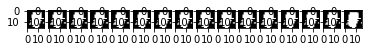

#####################################################
--> Number patterns: 17
Original images:



<Figure size 432x288 with 0 Axes>

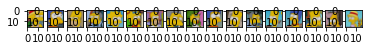


Binary versions:



<Figure size 432x288 with 0 Axes>

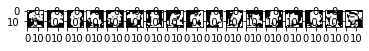


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

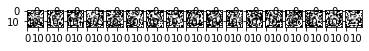

-6067.896193771627 	 as energy at time point  0
-7127.633217993081 	 as energy at time point  1
-7356.91349480969 	 as energy at time point  2
-7425.197231833913 	 as energy at time point  3
-7450.581314878897 	 as energy at time point  4
-7450.941176470594 	 as energy at time point  5

Redone pictures:



<Figure size 432x288 with 0 Axes>

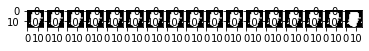

#####################################################
--> Number patterns: 18
Original images:



<Figure size 432x288 with 0 Axes>

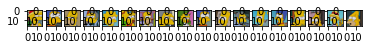


Binary versions:



<Figure size 432x288 with 0 Axes>

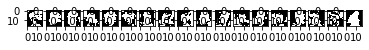


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

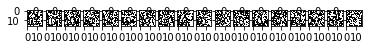

-5971.370370370373 	 as energy at time point  0
-7301.04938271605 	 as energy at time point  1
-7699.617283950614 	 as energy at time point  2
-7879.049382716045 	 as energy at time point  3
-7906.555555555549 	 as energy at time point  4
-7909.7901234567835 	 as energy at time point  5
-7911.469135802461 	 as energy at time point  6
-7911.864197530855 	 as energy at time point  7
-7912.0123456790025 	 as energy at time point  8
-7912.111111111101 	 as energy at time point  9

Redone pictures:



<Figure size 432x288 with 0 Axes>

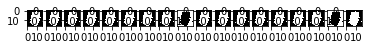

#####################################################
--> Number patterns: 19
Original images:



<Figure size 432x288 with 0 Axes>

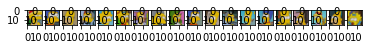


Binary versions:



<Figure size 432x288 with 0 Axes>

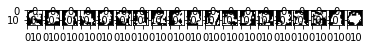


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

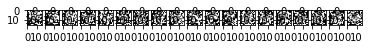

-5932.426592797783 	 as energy at time point  0
-7234.725761772854 	 as energy at time point  1
-7503.944598337949 	 as energy at time point  2
-7641.445983379504 	 as energy at time point  3
-7797.556786703603 	 as energy at time point  4
-7821.601108033244 	 as energy at time point  5
-7823.6620498614975 	 as energy at time point  6
-7824.105263157898 	 as energy at time point  7

Redone pictures:



<Figure size 432x288 with 0 Axes>

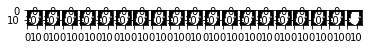

#####################################################
--> Number patterns: 20
Original images:



<Figure size 432x288 with 0 Axes>

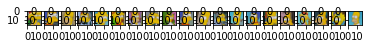


Binary versions:



<Figure size 432x288 with 0 Axes>

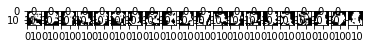


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

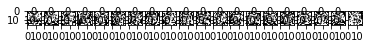

-6368.5199999999995 	 as energy at time point  0
-7406.649999999999 	 as energy at time point  1
-7618.110000000001 	 as energy at time point  2
-7719.38 	 as energy at time point  3
-7755.92 	 as energy at time point  4
-7763.969999999999 	 as energy at time point  5
-7765.2699999999995 	 as energy at time point  6
-7766.649999999999 	 as energy at time point  7
-7767.0999999999985 	 as energy at time point  8

Redone pictures:



<Figure size 432x288 with 0 Axes>

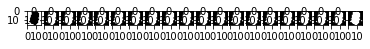

#####################################################
--> Number patterns: 21
Original images:



<Figure size 432x288 with 0 Axes>

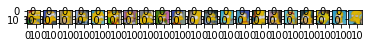


Binary versions:



<Figure size 432x288 with 0 Axes>

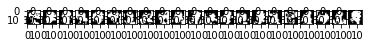


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

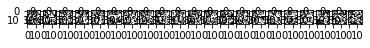

-6801.54195011338 	 as energy at time point  0
-7847.61904761905 	 as energy at time point  1
-7935.38321995465 	 as energy at time point  2
-7944.80725623583 	 as energy at time point  3
-7946.562358276644 	 as energy at time point  4
-7946.8934240362805 	 as energy at time point  5
-7946.95238095238 	 as energy at time point  6

Redone pictures:



<Figure size 432x288 with 0 Axes>

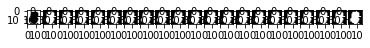

#####################################################
--> Number patterns: 22
Original images:



<Figure size 432x288 with 0 Axes>

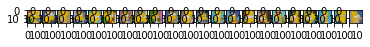


Binary versions:



<Figure size 432x288 with 0 Axes>

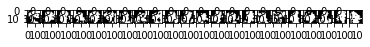


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

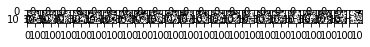

-6752.173553719008 	 as energy at time point  0
-7805.776859504131 	 as energy at time point  1
-7961.876033057852 	 as energy at time point  2
-7983.793388429756 	 as energy at time point  3
-7986.454545454552 	 as energy at time point  4

Redone pictures:



<Figure size 432x288 with 0 Axes>

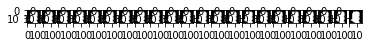

#####################################################
--> Number patterns: 23
Original images:



<Figure size 432x288 with 0 Axes>

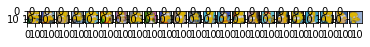


Binary versions:



<Figure size 432x288 with 0 Axes>

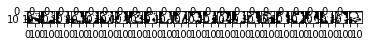


Corrupted pictures:


<Figure size 432x288 with 0 Axes>

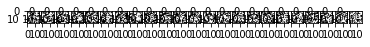

-6138.971644612476 	 as energy at time point  0
-7413.406427221172 	 as energy at time point  1
-7634.805293005672 	 as energy at time point  2
-7667.391304347826 	 as energy at time point  3
-7672.521739130432 	 as energy at time point  4
-7672.608695652171 	 as energy at time point  5

Redone pictures:



<Figure size 432x288 with 0 Axes>

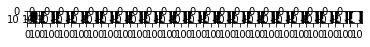

In [13]:
# Q3
img_batch = load_random_simpsons_face(3*8, 16)
for img_batch_reduced_ind in range(1,img_batch.shape[0]):
    print('#####################################################')
    print('--> Number patterns:', img_batch_reduced_ind)
    img_batch_reduced = img_batch[:img_batch_reduced_ind]
    
    print('Original images:\n')
    show_images(img_batch_reduced) # Q1

    img_bin_batch_X = convert_images2bin_pattern(img_batch_reduced)
    print('\nBinary versions:\n')
    show_images(img_bin_batch_X, cmap='binary') # Q1

    field = ClassicalHopfield(256)
    field.store(img_bin_batch_X) # adjust W

    # Distort patterns:
    img_distort_batch = corrupt_binary_patterns(img_bin_batch_X, 0.4)
    print('\nCorrupted pictures:')
    show_images(img_distort_batch, cmap='binary') # Q1

    # Get the original patterns back:
    redone_pattern_X = field.retrieve(img_distort_batch, 100)
    print('\nRedone pictures:\n')
    show_images(redone_pattern_X, cmap='binary') # Q1


Q3: 5 patterns: less fitting output but still okay. 6 patterns: only one kind of pattern predicted for all inputs. Therefore, number patterns >= 6 can't be handled anymore.

Notebook done by Nina Braunmiller (k11923286)

## Exercise 5: Use the provided Dense Hopfield Network with exponential energy function and test is as before
The dense Hopfield Networks by [Demircigil et al. 2017](https://arxiv.org/abs/1702.01929) replace the quadratic form of the energy function with an exponential function. The energy function thus becomes:
$$\text{E}(\boldsymbol{\xi}) = -\sum_{i=1}^N \exp(\boldsymbol{x}_i^T\boldsymbol{\xi}).$$

Here $\boldsymbol{\xi}$ denotes the state pattern i.e. a corrupted pattern which is going to be restored with the modern Hopfield network and $\boldsymbol{x}_i$ denotes the stored pattern $i$ as a col-vector (Note that they are stored as row vectors in $\boldsymbol{X}$). 

The componentwise update rule for polar patterns $\boldsymbol{\xi} ∈ \{-1,+1\}^D$ is given by:
$$\boldsymbol{\xi}^\text{new}_k = \text{sgn}\left[-E\left(\boldsymbol{\xi}^{(+1,k)}\right) + E\left(\boldsymbol{\xi}^{(-1,k)}\right) \right].$$

Where $\boldsymbol{\xi}^\text{new}_k$ denotes the k-th component of the new state pattern and $\boldsymbol{\xi}^{(\pm1,k)}$ denotes the old state pattern $\boldsymbol{\xi}$ where the k-th component was set to $+1$ or $-1$ respectively.

The class `DenseHopfield` provides similar to the classical Hopfield example the three functions `store(X)`, `retrieve(X)` and `energy(X)` which are already implemented. Import the class from `models.py` and use the existing functions to answer the same three questions as for the classical Hopfield network. How do they compare?

*Question 1: What do you observe? Plot each step of your experiment. That is show the original images, the patterns, the corrupted and retrieved ones.*

*Question 2: Fixing the number of patterns to 5 and average over 100 trials, what is the maximum probability of flips the Hopfield network can handle? Give experimental evidence via some plots.*

*Question 3: Fixing the probability of flips to 0.4 and average over 100 trials, what is the maximum number of patterns the Hopfield network can restore? Give experimental evidence via some plots.*

In [8]:
from models import DenseHopfield

In [9]:
########## YOUR SOLUTION HERE ##########

## Exercise 6: 
1. Argue why the proposed update rule minimizes the exponential energy function.
2. Incorporate the lse function into the energy function of the dense Hopfield network using the definition of the lse function below:
$$\text{lse}(\beta, \boldsymbol{z}) = \beta^{-1} \log \left( \sum_{l=1}^N \text{exp}(\beta z_l) \right).$$


########## YOUR SOLUTION HERE ##########

## Exercise 7: Test the Modern Hopfield Network with the lse energy function
The modern Hopfield Network by Ramsauer et al. 2020 extends the energy function of Dense Hopfield networks to be able to work with continuous-valued patterns. The energy function is now:
$$\text{E} = -\text{lse}\big(\beta,\boldsymbol{X}^T\boldsymbol{\xi}\big) + \frac{1}{2} \boldsymbol{\xi}^T\boldsymbol{\xi} + \beta^{-1}\log N + \frac{1}{2} M^2$$

Here M denotes the largest norm of all stored patterns. The new update rule for patterns $\boldsymbol{\xi} \in \mathbb{R}^D$ is given by:
$$\boldsymbol{\xi}^{\text{new}} = \boldsymbol{X}\text{softmax}\big(\beta \boldsymbol{X}^T \boldsymbol{\xi} \big).$$


1. Since the patterns are now in a continuous domain we need to write new converter functions. Write the function `convert_images2cont_pattern(images)` which converts the image to gray scale that is the image has only one channel and it's pixels lie in the interval $[-1,+1]$. The red channel is weighted with 0.21, the green channel with 0.72 and the blue channel with 0.07.

2. The distortion function needs to be adapted as well. Write the function `corrupt_cont_patterns(patterns, p_flip)` which sets each pixel with the probability `p_flip` to the value 0.

3. Test your functions and visualize the results. i.e. show the original image, the gray-scale image and the corrupted image for a) 0.1 and b) 0.4 using `corrupt_cont_patterns` and try to restore the original patterns using `retrieve(self,X)` of the Modern Hopfield network (see task 4). For continous patterns use the cmap `gray` in the function `plt.imshow()`. 

4. The class `ModernHopfield` provides similar to the classical Hopfield example the three functions `store(X)`, `retrieve(X)` and `energy(X)` which are already implemented. Import the class from `models.py` and use the existing functions to answer the same three questions as for the classical Hopfield network. Note that we can provide a $\beta$ parameter during instantiation of the ModernHopfield network. Use $\beta=32$ and use `max_iter=100` in the retrieve-function. How do they compare? 

*Question 1: What do you observe? Plot each step of your experiment. That is show the original images, the patterns, the corrupted and retrieved ones.*

*Question 2: Fixing the number of patterns to 5 and average over 100 trials, what is the maximum probability of flips the Hopfield network can handle? Give experimental evidence via some plots.*

*Question 3: Fixing the probability of flips to 0.4 and average over 100 trials, what is the maximum number of patterns the Hopfield network can restore? Give experimental evidence via some plots.*

5. Do you recognize the update rule? Explain how it relates to Key-Value attention?

In [10]:
from models import ModernHopfield

def convert_images2cont_pattern(images):
    """converts images to continuous black and white with pixel values
    in interval [-1,+1]

    Args:
        images (np.ndarray): batch of images as np.array of shape N x D x D x C

    Returns:
        np.ndarray: numpy array with shape N x D*D
    """
    N, D,_,C = images.shape
    assert C == 3, 'invalid image shape'
########## YOUR SOLUTION HERE ##########


def corrupt_cont_patterns(patterns, p_flip=.1):
    """corrupts continuous pattern by setting each pixel with probability p_flip to 0.
    A pixel has values in the interva [-1, +1].
    
    Args:
        patterns (np.ndarray): batch of patterns as np.array of shape N x D**2
        
    Returns:
        np.ndarray: corrupted numpy array with same shape as patterns
    """
    N, D2 = patterns.shape
########## YOUR SOLUTION HERE ##########

## Bonus Excercise 8: Modern Hopfield behaviour for different betas

Investigate and visualize how the modern Hopfield storage capacity and error resilience behaves with different $\beta$.


In [11]:
########## YOUR SOLUTION HERE ##########